Code for the paper: *Exploring the Role of Altruism in Arrhenotoky with Dynamic Beehive Models*

By Zachary Nathan, with help from Daniel DiPietro and Olivia Chu

June 29, 2023

In [2]:
from scipy.integrate import solve_ivp
from tqdm.notebook import tqdm
import multiprocess as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import heatmap, lineplot
import math

### Configuration

In [3]:
# results figures
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)


config = {
    'tt': 10000,  # simulation timespan in units of 't'
    'k': 10000,  # carrying capacity, before exponential penalties kick in
    'w_0': 30.0,  # initial worker population
    'd_0': 5.0,  # initial drone population
    'l_w': 45.0,  # in units of 't', or time steps
    'l_d': 45.0,  # a 1/lifespan proportion will die in each time step, before penalties
    'e_w': 1.00,  # epsilon_w, proportion of energy donated by workers, 1.00 is optimal
    'e_q': 0.15,  # epsilon_q, proportion of energy donated by the queen, 0.15 is optimal
    'u_w': 3.0,  # cost for a worker to lay an egg
    'u_d': 0.5,  # cost for a drone to fertilize an egg (this kills the drone)
    'u_q': 1.5  # cost for the queen to lay an egg (economies of scale)
}

### Methods

In [4]:
## ODE model for beehive replicator dynamics ##
def ode_replicator(t, P, config):
    w, d = P
    
    ## Energy ##
    J_w = w * (1 - config['e_w'])  # worker pay-off: each gathers 1, keeping proportion 'epsilon' for themselves
    J_q = w * (1 - config['e_q']) * config['e_w']  # queen pay-off: energy given by workers, keeping proportion 'alpha'
    J_d = w * config['e_q'] * config['e_w']  # drone pay-off: leftover energy from workers and the queen
    
    ## Reproduction ##
    E_w = J_w / config['u_w']  # eggs laid by workers, which hatch into drones
    E_q = J_q / config['u_q']  # eggs laid by the queen, which hatch into workers if fertilized, otherwise drones
    E_d = min(E_q, d, J_d / config['u_d'])  # eggs fertilized by drones (only the queen's eggs are eligible)
    
    ## Death ##
    cf = max(1, np.exp((w + d) / config['k'] - 1))  # capacity factor: exponential penalty above the carrying capacity
    D_w = cf * (w / config['l_w'])  # a proportion 1/L_w dies to achieve the average lifespan L_w, before capacity penalties
    D_d = cf * (d / config['l_d']) + E_d  # drones have additional deaths from fertilization
    
    ## Populations ##
    w_dot = E_d - D_w  # workers: births from fertilized eggs, minus deaths
    d_dot = E_w + E_q - E_d - D_d  # drones: births from worker eggs and unfertilized queen eggs, minus deaths
    return (w_dot, d_dot)

In [5]:
def get_result(config):
    return solve_ivp(
        fun=ode_replicator,
        args=([config]),
        method='LSODA',
        t_span=(0, config['tt']),
        y0=(config['w_0'], config['d_0']),
        max_step=2.5
    )


def add_title_note(title, title_note):
    return title + ('\n' + title_note if title_note is not None else '')


def print_heatmap(data, n_ticks=11, title=None, show=True):
    n_ticks = 11
    ticks = np.linspace(0, len(data), n_ticks)
    ticklabels = ['{:.1f}'.format(i) for i in np.linspace(0, 1, n_ticks)]
    
    ax = heatmap(data)
    plt.xlabel('$\epsilon_q$')
    plt.xticks(ticks, ticklabels)
    plt.ylabel('$\epsilon_w$')
    plt.yticks(ticks, reversed(ticklabels))
    if title:
        plt.title(title)
    
    if show:
        plt.show()
    
    return ax

### Test Simulation

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  6.443e-02 ...  9.998e+03  1.000e+04]
        y: [[ 3.000e+01  3.029e+01 ...  2.628e+04  2.628e+04]
            [ 5.000e+00  5.114e+00 ...  4.815e+03  4.815e+03]]
      sol: None
 t_events: None
 y_events: None
     nfev: 4506
     njev: 209
      nlu: 209
Final population: 31095
Final w:d ratio: 5.458039891549808
Time to convergence: 93.21778924527014


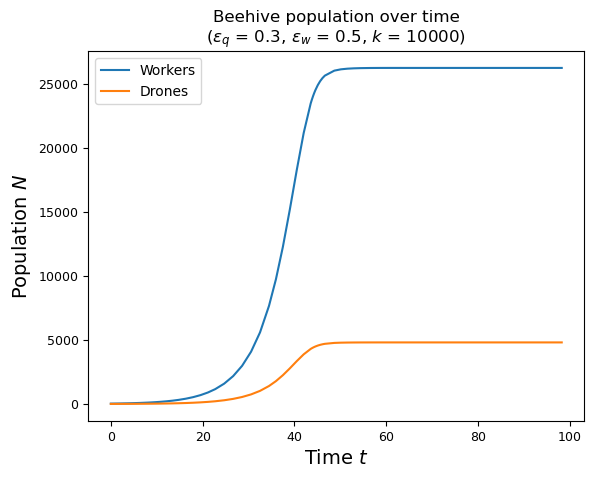

In [6]:
config['e_w'] = 0.5
config['e_q'] = 0.3

result = get_result(config)
print(result)

result_df = pd.DataFrame(result.y.T, copy=True)
result_df.index = result.t.T
result_df.columns = ['Workers', 'Drones']
lineplot(result_df[:100], dashes=False)
plt.xlabel('Time $t$')
plt.ylabel('Population $N$')
plt.title(f'Beehive population over time\n($\epsilon_q$ = {config["e_q"]}, $\epsilon_w$ = {config["e_w"]}, $k$ = {config["k"]})')

P_t = int(np.sum(result.y[:, -1]))
wd = result.y[0, -1] / result.y[1, -1]

i_convergence = np.argmax(np.abs(np.diff(np.sum(result.y, axis=0))) < 0.00001)
t_convergence = result.t[i_convergence + 1] if i_convergence > 0 else np.NAN
    
print(f'Final population: {P_t}')
print(f'Final w:d ratio: {wd}')
print(f'Time to convergence: {t_convergence}')

### Heatmap Simulations

In [7]:
def mp_wrapper(e_q):
    config['e_q'] = e_q
    
    # get_result() calls solve_ivp(), which uses the global epsilon values
    result = get_result(config)
    
    # total population N at the last time step
    P_t = int(np.sum(result.y[:, -1]))
    
    # ratio of drones to workers at the last time step
    dw = float(result.y[1, -1]) / float(result.y[0, -1])
    
    # find the time of convergence, which is the first time step where all
    # subsequent time steps have population changes less than min_change
    min_change = 1e-7
    time_steps = result.y.shape[1]
    i_con = time_steps - np.argmin(np.abs(np.diff(np.sum(result.y, axis=0)))[::-1] < min_change)
    t_con = result.t[i_con] if i_con < time_steps else np.NAN
    return (P_t, t_con, dw)


def simulate_heatmap(config, steps, show=False, title_note=None):

    # steps for epsilon from 0 to 1, default is 101 for increments of 0.01
    # 201+ is slower, but good for generating high-resolution figures
    # 101: 1m, 201: 2m, 401: 11m
    populations = np.zeros((steps, steps), dtype=float)
    convergences = np.zeros((steps, steps), dtype=float)
    ratios = np.zeros((steps, steps), dtype=float)

    for i, e_w in tqdm(enumerate(np.linspace(1, 0, steps)), total=steps):
        config['e_w'] = e_w
        pool = mp.Pool(processes=8)
        row = np.array(pool.map(mp_wrapper, np.linspace(0, 1, steps)))
        pool.close()
        populations[i] = row[:, 0]
        convergences[i] = row[:, 1]
        ratios[i] = row[:, 2]

    if show:
        # populations
        print_heatmap(populations, title=add_title_note(
            f'Population totals\n(t={config["tt"]}, k={config["k"]})',
            title_note
        ))

        # ratios (substitute NAN for zero-populations)
        r2 = np.copy(ratios)
        r2[populations == 0] = np.NAN
        ax = print_heatmap(np.log(r2), show=False, title=add_title_note(
            f'Population compositions, logarithmic\n(log drones per worker, t={config["tt"]})',
            title_note
        ))
        plt.show()

        # times of convergence
        print_heatmap(np.log(convergences), title=add_title_note(
            f'Times of population convergence, logarithmic\n(white: not converged by t={config["tt"]})',
            title_note
        ))

    return populations, convergences, ratios


steps = 401
populations, convergences, ratios = simulate_heatmap(config, steps)

  0%|          | 0/401 [00:00<?, ?it/s]

### Results

In [7]:
def index_to_epsilons(index):
    global steps
    assert index < steps ** 2
    return (
        np.linspace(1, 0, steps)[math.floor(index / steps)], # epsilon_w
        np.linspace(0, 1, steps)[math.floor(index % steps)]  # epsilon_q
    )

print(f'max population is {populations.max()}, found at (e_w, e_q) = {index_to_epsilons(populations.argmax())}')

# ratios (substitute NAN for zero-populations)
ratios[populations == 0] = np.NAN
print(f'max drones per worker is {np.nanmax(ratios)}, found at (e_w, e_q) = {index_to_epsilons(np.nanargmax(ratios))}')
print(f'min drones per worker is {np.nanmin(ratios)}, found at (e_w, e_q) = {index_to_epsilons(np.nanargmin(ratios))}')

print(f'min time to convergence is {np.nanmin(convergences)}, found at (e_w, e_q) = {index_to_epsilons(np.nanargmin(convergences))}')

max population is 34479.0, found at (e_w, e_q) = (1.0, 0.13)
max drones per worker is 26.458937198067638, found at (e_w, e_q) = (0.8625, 0.0125)
min drones per worker is 0.02187735728576222, found at (e_w, e_q) = (0.98, 0.9425)
min time to convergence is 65.93083919205344, found at (e_w, e_q) = (0.9675, 0.1625)


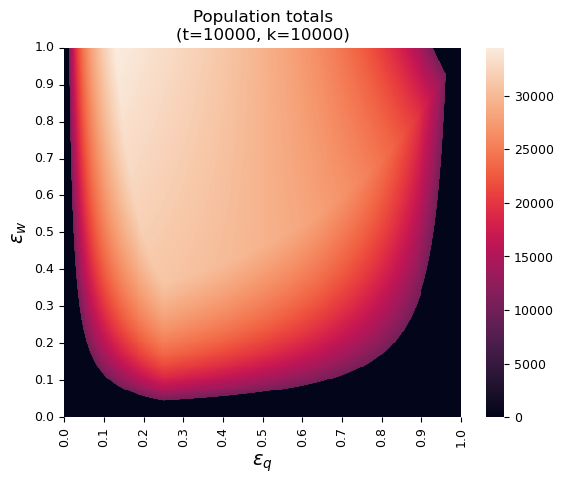

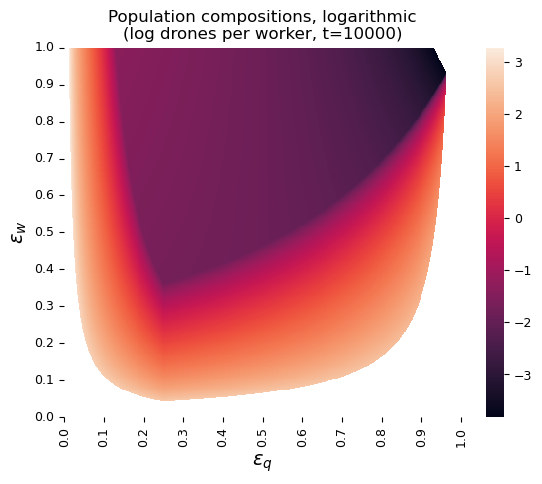

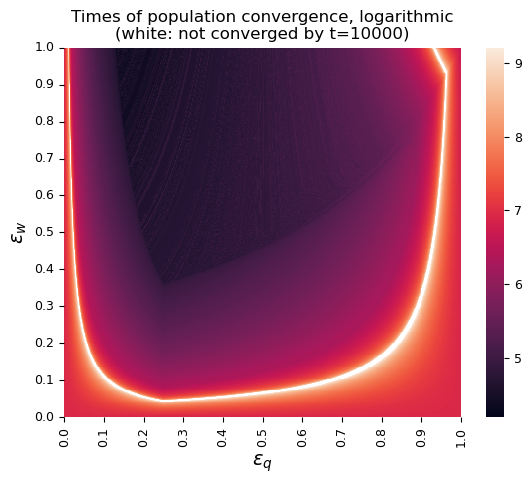

<AxesSubplot: title={'center': 'Times of population convergence, logarithmic\n(white: not converged by t=10000)'}, xlabel='$\\epsilon_q$', ylabel='$\\epsilon_w$'>

In [8]:
# populations
print_heatmap(populations, title=f'Population totals\n(t={config["tt"]}, k={config["k"]})')

# ratios
ax = print_heatmap(np.log(ratios), show=False, title=f'Population compositions, logarithmic\n(log drones per worker, t={config["tt"]})')
plt.show()

# times of convergence
print_heatmap(np.log(convergences), title=f'Times of population convergence, logarithmic\n(white: not converged by t={config["tt"]})')

### Analysis

In [9]:
# analysis figures helpers

# vertical line
def plot_vline(size=steps):
    plt.plot([size * 0.255, size * 0.255], [0, size], color='dodgerblue', linestyle='dashed')

# viability (left)
def plot_ac(size=steps):
    xs = np.arange(size * 0.005, size * 0.255)
    plt.plot(xs, size * (1 - config['u_d'] / config['l_w'] / (xs / size)), color='dodgerblue', linestyle='dashed')

# viability (right)
def plot_bd(size=steps):
    xs = np.arange(size * 0.255, size)
    plt.plot(xs, size * (1 - config['u_q'] / config['l_w'] / (1 - (xs / size))), color='dodgerblue', linestyle='dashed')

# limiting factor (left)
def plot_ae(size=steps):
    xs = np.arange(size * 0.125, size * 0.255)
    plt.plot(xs, size * (1 - config['l_d'] / ((xs / size) + 14 * (xs / size) * config['l_d'] - config['l_d'])), color='dodgerblue', linestyle='dashed')

# limiting factor (right)
def plot_bf(size=steps):
    xs = np.arange(size * 0.255, size)
    plt.plot(xs, size * (1 - (-1 * config['u_q'] * config['l_d'])/(((xs / size) - 1) * config['u_w'] + (2 * (xs / size) - 3) * config['u_q'] * config['l_d'])), color='dodgerblue', linestyle='dashed')

# letter labels
def plot_letters(letters='ABCDEF', size=steps):
    if 'A' in letters:
        plt.text(size*0.10, size*0.65, 'A', color='dodgerblue', weight='bold')
    if 'B' in letters:
        plt.text(size*0.60, size*0.70, 'B', color='dodgerblue', weight='bold')
    if 'C' in letters:
        plt.text(size*0.05, size*0.95, 'C', color='dodgerblue', weight='bold')
    if 'D' in letters:
        plt.text(size*0.90, size*0.90, 'D', color='dodgerblue', weight='bold')
    if 'E' in letters:
        plt.text(size*0.20, size*0.15, 'E', color='dodgerblue', weight='bold')
    if 'F' in letters:
        plt.text(size*0.50, size*0.20, 'F', color='dodgerblue', weight='bold')
        
def plot_annotations(lines=('V', 'AC', 'BD', 'AE', 'BF'), letters='ABCDEF', size=steps):
    if 'V' in lines:
        plot_vline(size=size)
    if 'AC' in lines:
        plot_ac(size=size)
    if 'BD' in lines:
        plot_bd(size=size)
    if 'AE' in lines:
        plot_ae(size=size)
    if 'BF' in lines:
        plot_bf(size=size)
    plot_letters(letters, size=size)

#plot_annotations()

In [11]:
def analytical(e_w, e_q, config, left=True, right=True, viability_left=True, viability_right=True, undefined=True):
    if e_q <= 0.25:
        if left and (not undefined or e_q * e_w / config['u_w'] < config['l_d'] / config['u_w'] * (1 + e_w * (1 - 14 * e_q))):
            # defined
            if not viability_left or e_q * e_w > config['u_d'] / config['l_w']:
                # viable
                return config['k'] * (np.log(config['l_w'] * e_q * e_w / config['u_d']) + 1) if e_q * e_w > 0 else 0
            else:
                # non-viable
                return 0
        else:
            # undefined
            return np.NAN
    else:
        if right and (not undefined or (1 - e_q) * e_w / config['u_q'] < config['l_d'] / config['u_w'] * (1 + e_w * (2 * e_q - 3))):
            # defined
            if not viability_right or (1 - e_q) * e_w > config['u_q'] / config['l_w']:
                # viable
                return config['k'] * (np.log(config['l_w'] * (1 - e_q) * e_w / config['u_q']) + 1) if (1 - e_q) * e_w > 0 else 0
            else:
                # non-viable
                return 0
        else:
            # undefined
            return np.NAN
        
        
def analytical_matrix(steps=steps, left=True, right=True, viability_left=True, viability_right=True, undefined=True):
    return [[
            analytical(
                e_w, e_q, config, left=left, right=right,
                viability_left=viability_left, viability_right=viability_right, undefined=undefined
            ) for e_q in np.linspace(0, 1, steps)
        ] for e_w in np.linspace(1, 0, steps)]

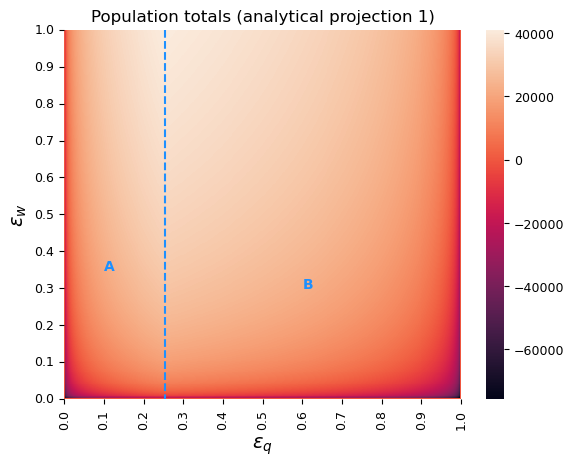

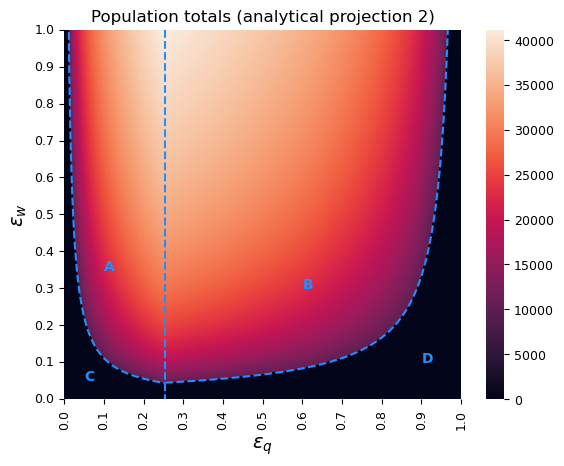

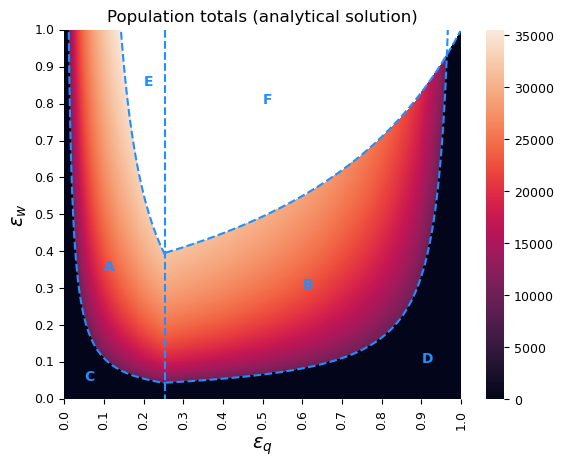

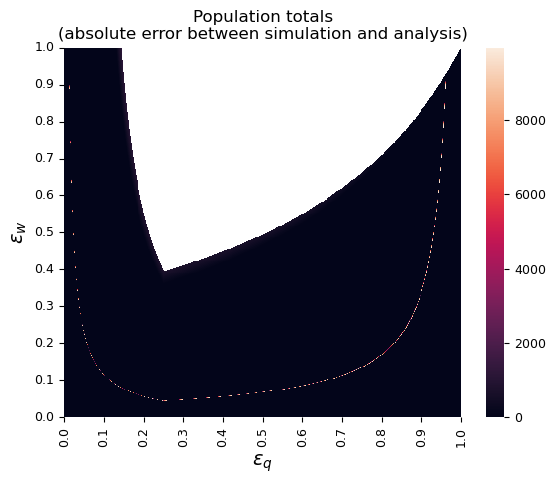

In [12]:
# analysis figures

# regions A and B only
ar = analytical_matrix(viability_left=False, viability_right=False, undefined=False)
ax = print_heatmap(ar, show=False, title='Population totals (analytical projection 1)')
plot_annotations(lines=('V'), letters='AB')
plt.show()

# viability
ar = analytical_matrix(undefined=False)
ax = print_heatmap(ar, show=False, title='Population totals (analytical projection 2)')
plot_annotations(lines=('V', 'AC', 'BD'), letters='ABCD')
plt.show()

# full heatmap
ar = analytical_matrix()
ax = print_heatmap(ar, show=False, title='Population totals (analytical solution)')
plot_annotations()
plt.show()

# final error
ax = print_heatmap(np.abs(ar-populations), show=False, title='Population totals\n(absolute error between simulation and analysis)')
#plot_annotations(lines=('V', 'AC', 'BD', 'AE', 'BF'), letters='ABCDEF')
plt.show()

### Supplementary Figures

  0%|          | 0/201 [00:00<?, ?it/s]

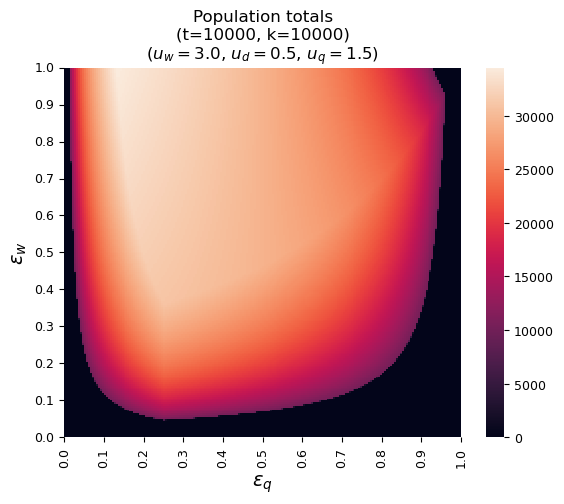

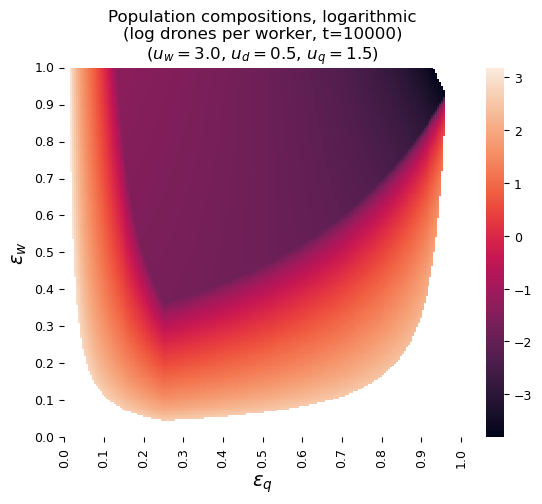

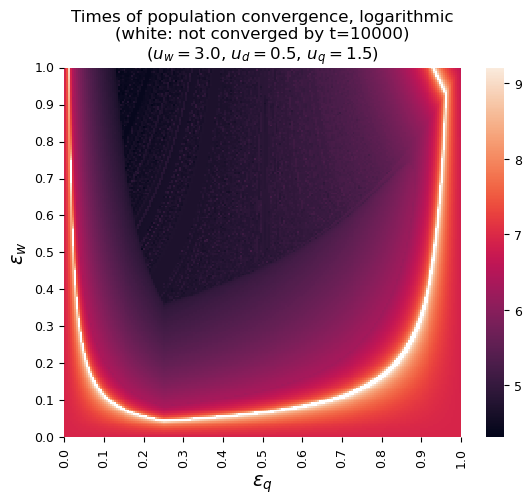

  0%|          | 0/201 [00:00<?, ?it/s]

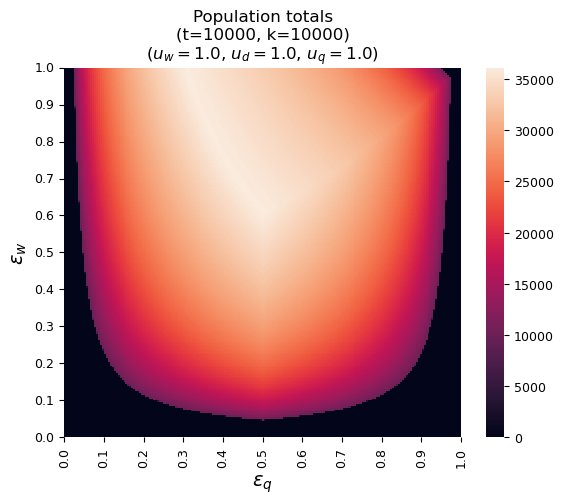

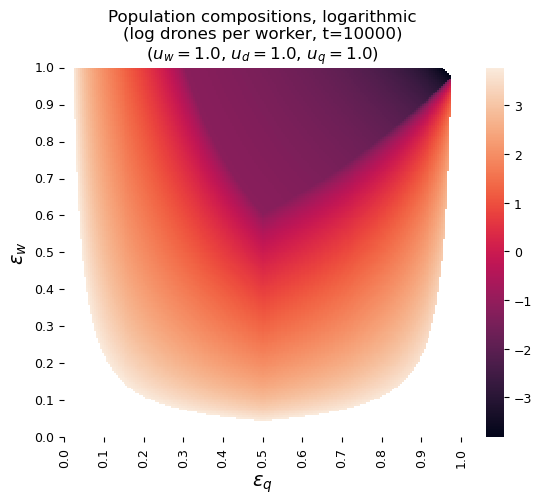

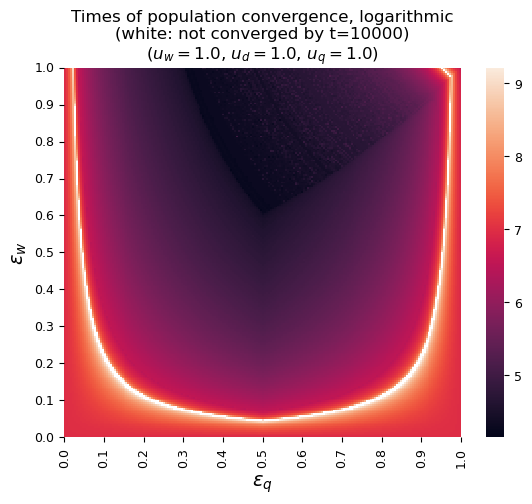

  0%|          | 0/201 [00:00<?, ?it/s]

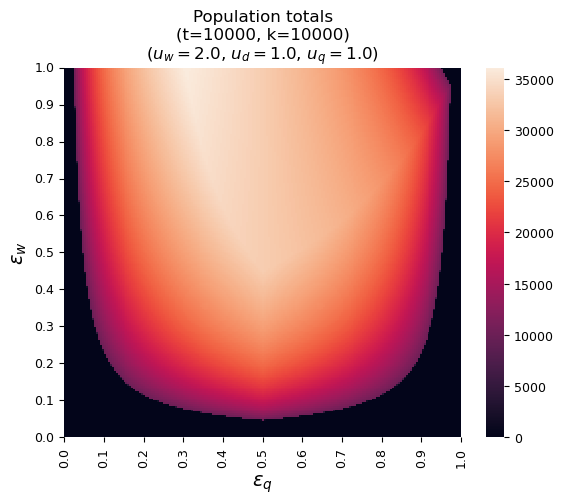

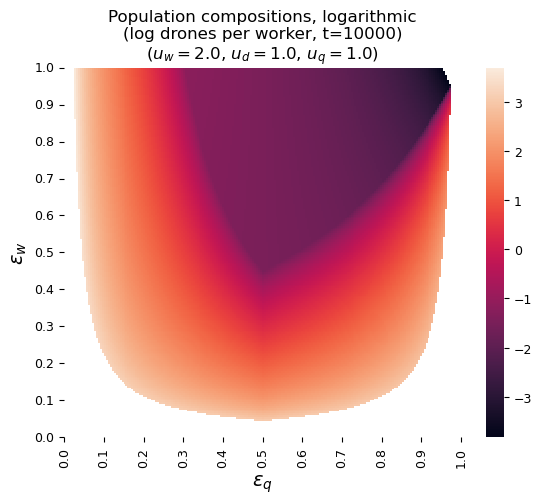

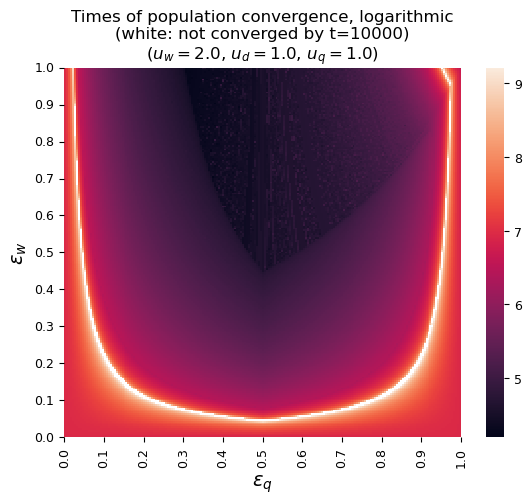

  0%|          | 0/201 [00:00<?, ?it/s]

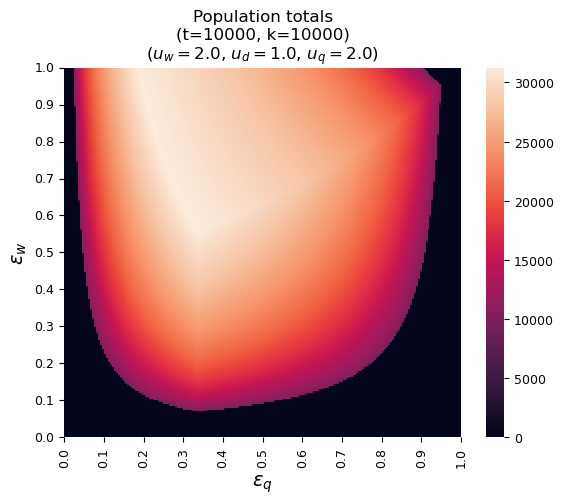

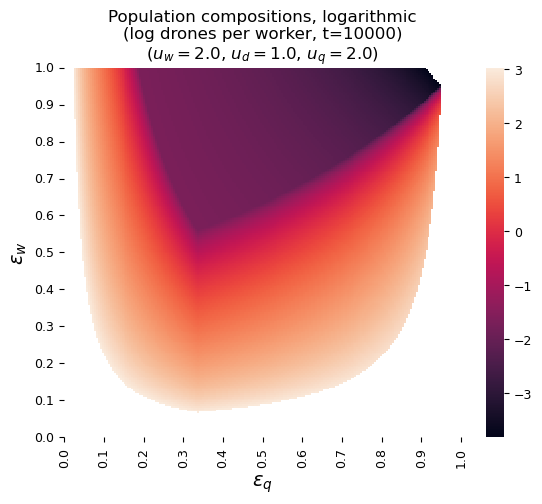

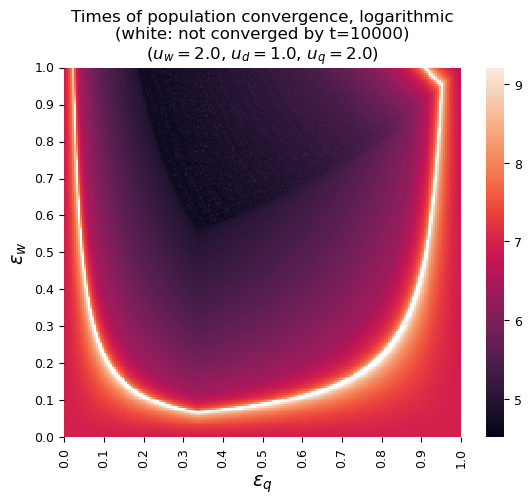

  0%|          | 0/201 [00:00<?, ?it/s]

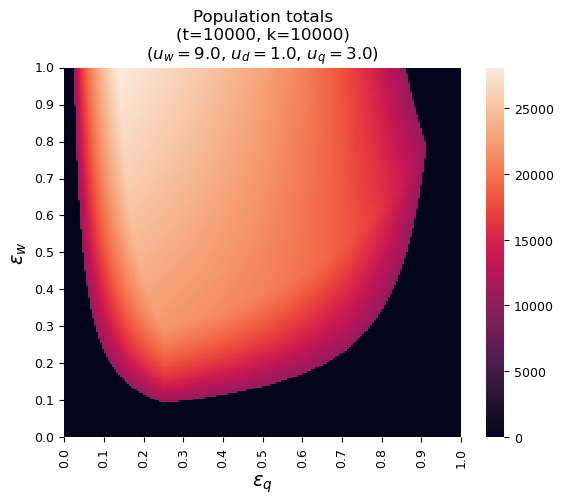

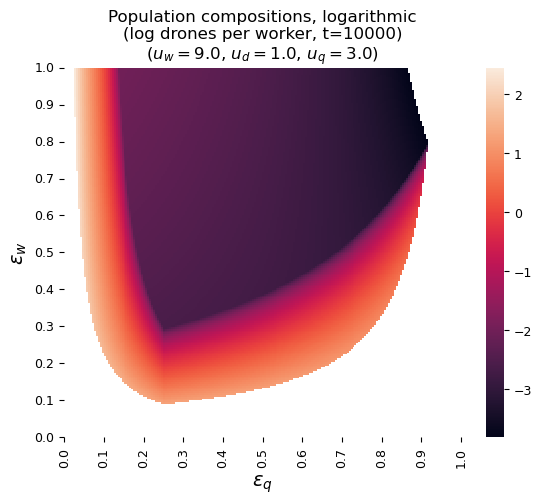

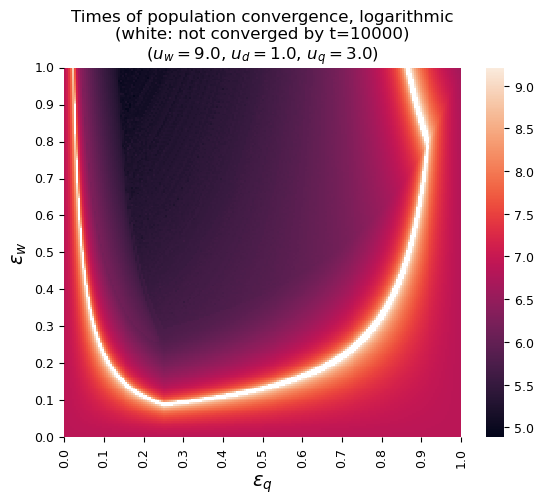

  0%|          | 0/201 [00:00<?, ?it/s]

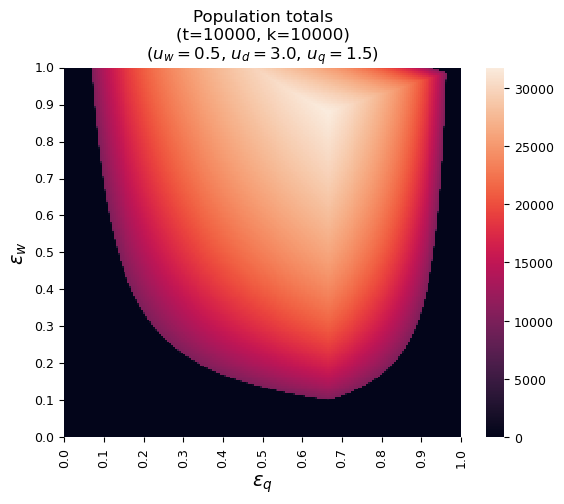

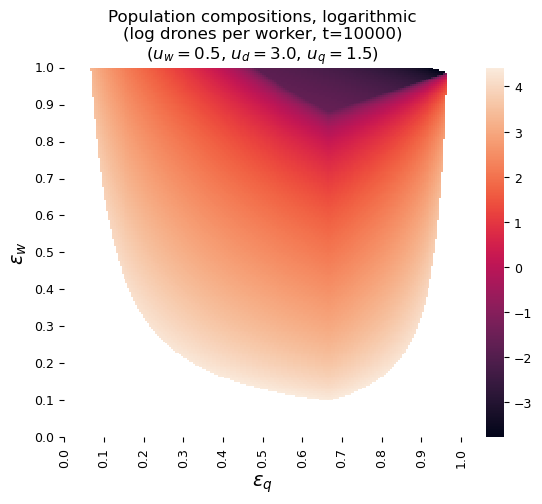

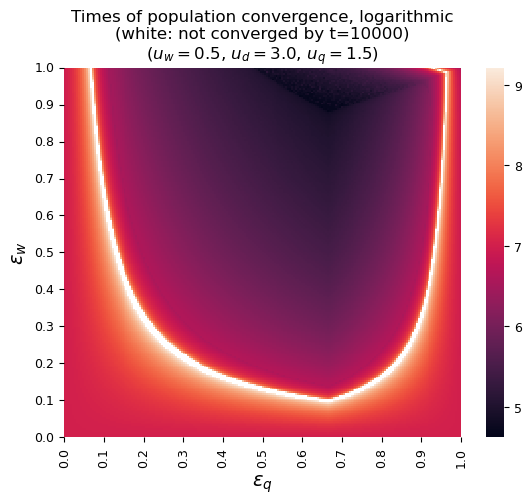

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[1042.75728825, 1090.33729173, 1152.92154368, ...,  879.20129001,
          810.29212429,  757.84611594],
        [1042.74802642, 1090.32725757, 1152.91067191, ..., 1074.05714355,
          929.03769227,  851.67447596],
        [1045.2388874 , 1090.3173561 , 1152.89994381, ..., 1116.08732425,
          965.81123305,  880.64695855],
        ...,
        [1094.40892367, 1094.40942127, 1094.40991913, ..., 1096.91300854,
         1094.41204328, 1094.41107896],
        [1094.40677805, 1094.40702651, 1094.40727503, ..., 1094.40881229,
         1094.40833086, 1094.40784964],
        [1094.40464203, 1094.40464203, 1094.40464203, ..., 1094.40464203,
         1094.40464203, 1094.40464203]]),
 array([[6.35840932e+03, 3.95999952e+02, 1.96000000e

In [13]:
##### defaults #####
config = {
    'tt': 10000,  # simulation timespan in units of 't'
    'k': 10000,  # carrying capacity, before exponential penalties kick in
    'w_0': 30.0,  # initial worker population
    'd_0': 5.0,  # initial drone population
    'l_w': 45.0,  # in units of 't', or time steps
    'l_d': 45.0,  # a 1/lifespan proportion will die in each time step, before penalties
    'e_w': 1.00,  # epsilon_w, proportion of energy donated by workers, 1.00 is optimal
    'e_q': 0.15,  # epsilon_q, proportion of energy donated by the queen, 0.15 is optimal
    'u_w': 3.0,  # cost for a worker to lay an egg
    'u_d': 0.5,  # cost for a drone to fertilize an egg (this kills the drone)
    'u_q': 1.5  # cost for the queen to lay an egg (economies of scale)
}

steps = 201

simulate_heatmap(config, steps, show=True, title_note=f'($u_w={config["u_w"]}$, $u_d={config["u_d"]}$, $u_q={config["u_q"]}$)')

config['u_w'] = 1.0
config['u_d'] = 1.0
config['u_q'] = 1.0

simulate_heatmap(config, steps, show=True, title_note=f'($u_w={config["u_w"]}$, $u_d={config["u_d"]}$, $u_q={config["u_q"]}$)')

config['u_w'] = 2.0
config['u_d'] = 1.0
config['u_q'] = 1.0

simulate_heatmap(config, steps, show=True, title_note=f'($u_w={config["u_w"]}$, $u_d={config["u_d"]}$, $u_q={config["u_q"]}$)')

config['u_w'] = 2.0
config['u_d'] = 1.0
config['u_q'] = 2.0

simulate_heatmap(config, steps, show=True, title_note=f'($u_w={config["u_w"]}$, $u_d={config["u_d"]}$, $u_q={config["u_q"]}$)')

config['u_w'] = 9.0
config['u_d'] = 1.0
config['u_q'] = 3.0

simulate_heatmap(config, steps, show=True, title_note=f'($u_w={config["u_w"]}$, $u_d={config["u_d"]}$, $u_q={config["u_q"]}$)')

config['u_w'] = 0.5
config['u_d'] = 3.0
config['u_q'] = 1.5

simulate_heatmap(config, steps, show=True, title_note=f'($u_w={config["u_w"]}$, $u_d={config["u_d"]}$, $u_q={config["u_q"]}$)')

  0%|          | 0/201 [00:00<?, ?it/s]

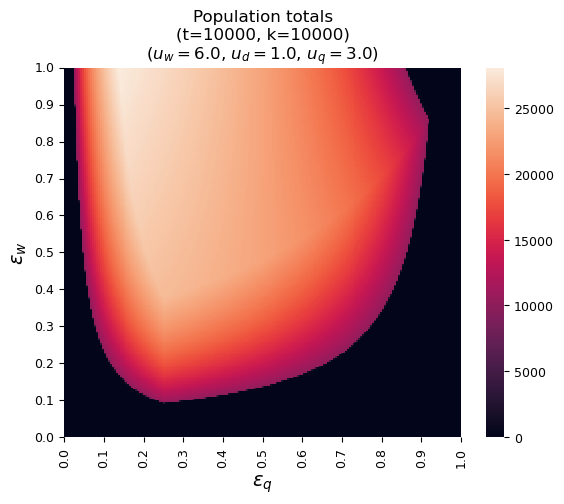

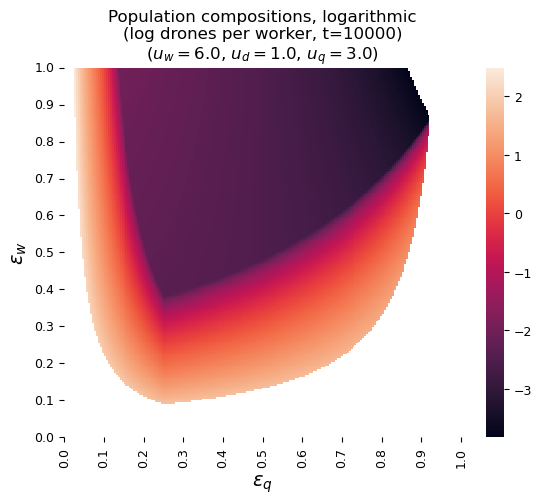

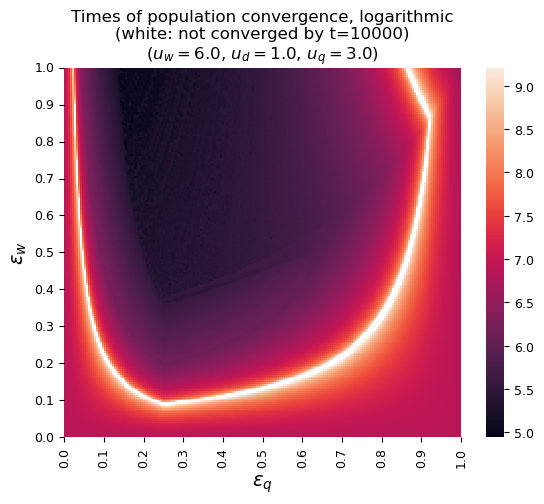

  0%|          | 0/201 [00:00<?, ?it/s]

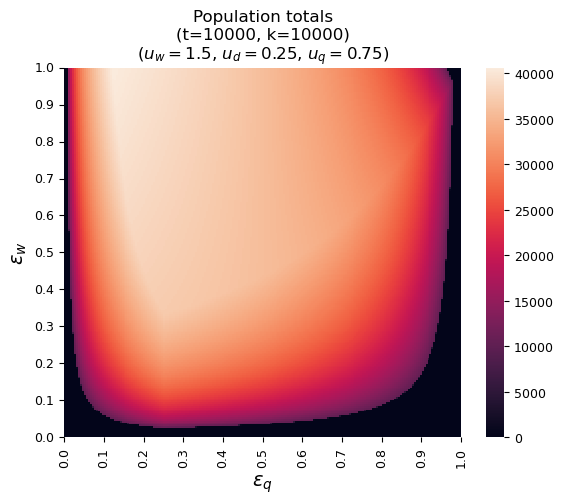

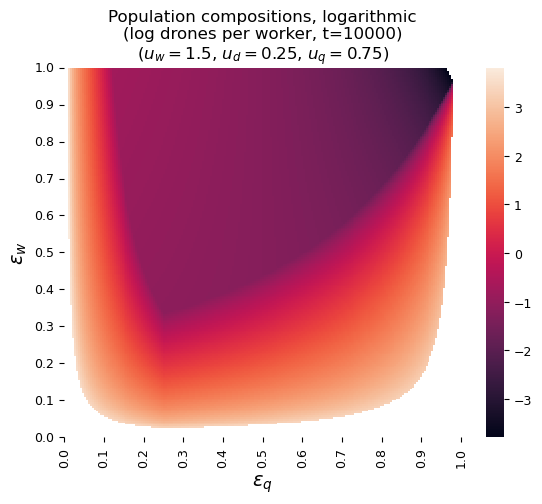

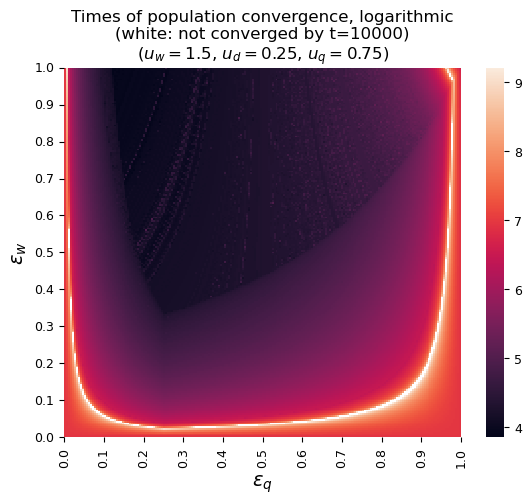

  0%|          | 0/201 [00:00<?, ?it/s]

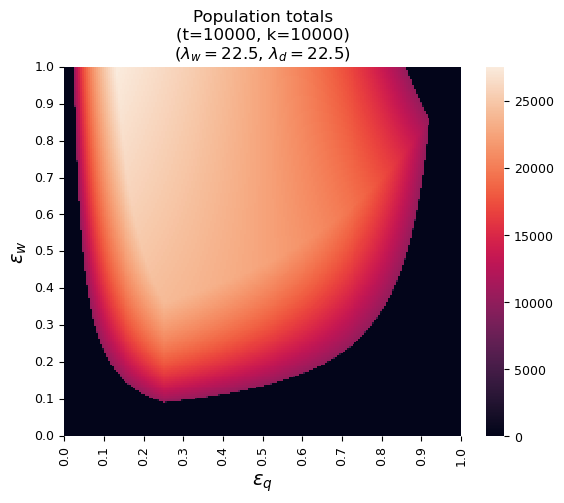

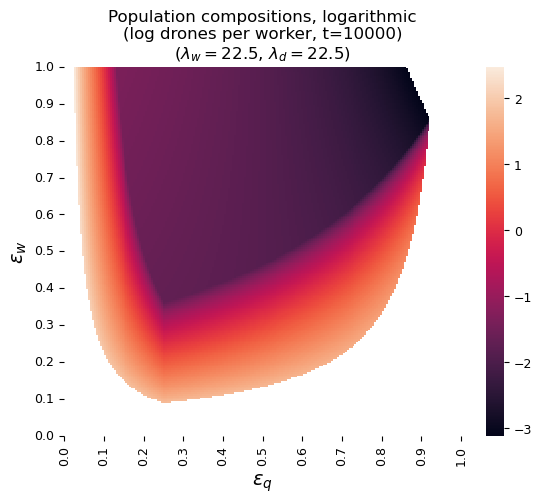

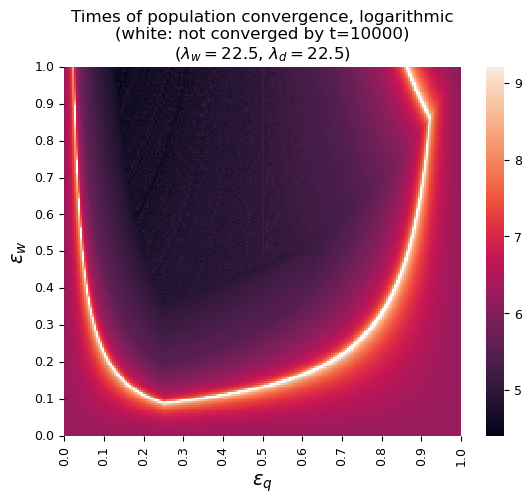

  0%|          | 0/201 [00:00<?, ?it/s]

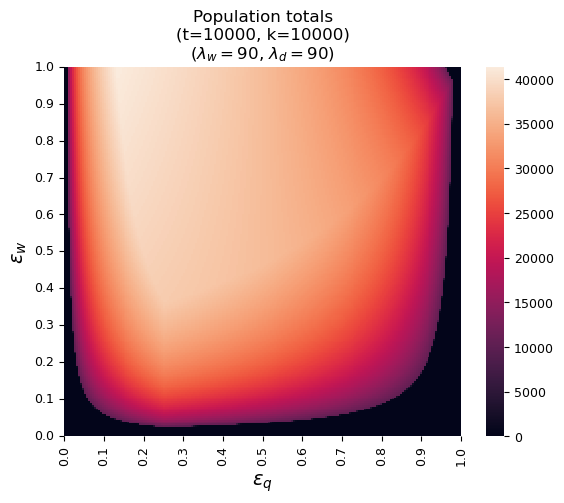

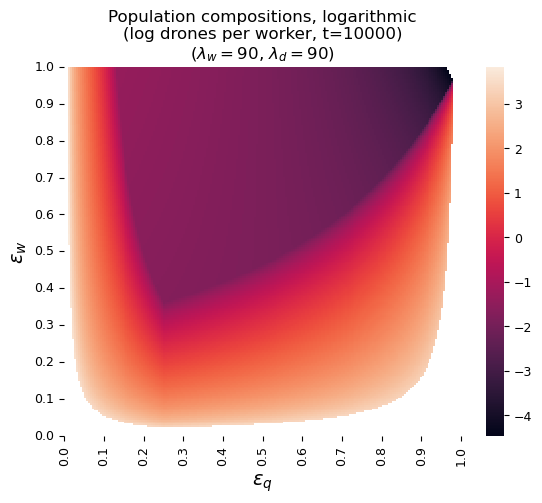

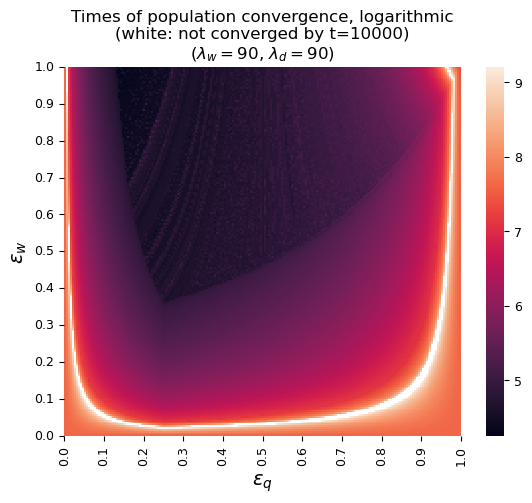

  0%|          | 0/201 [00:00<?, ?it/s]

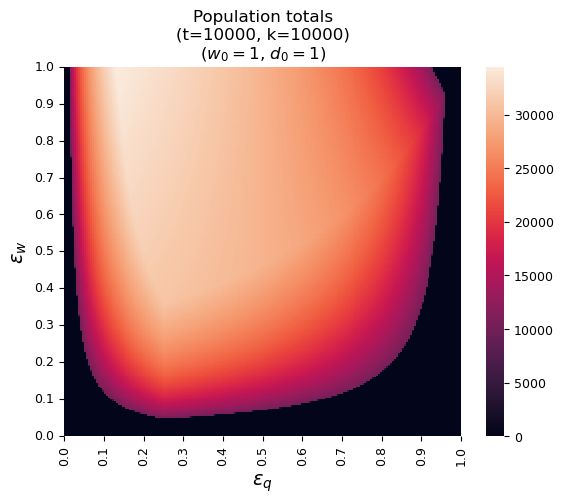

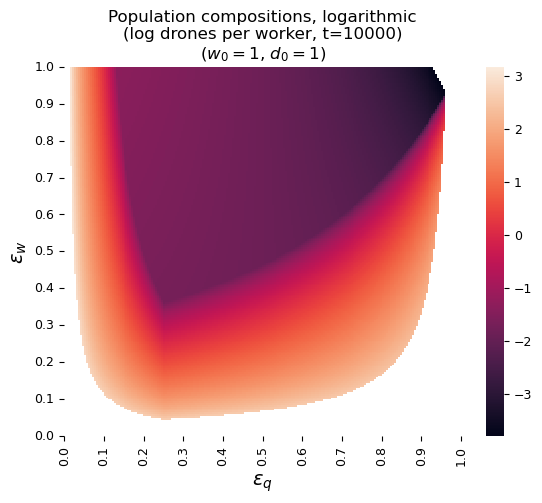

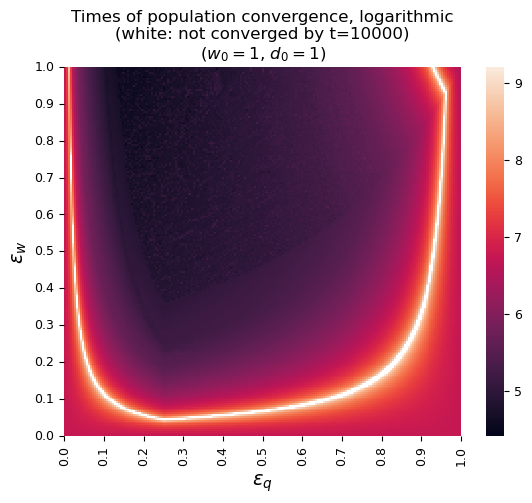

  0%|          | 0/201 [00:00<?, ?it/s]

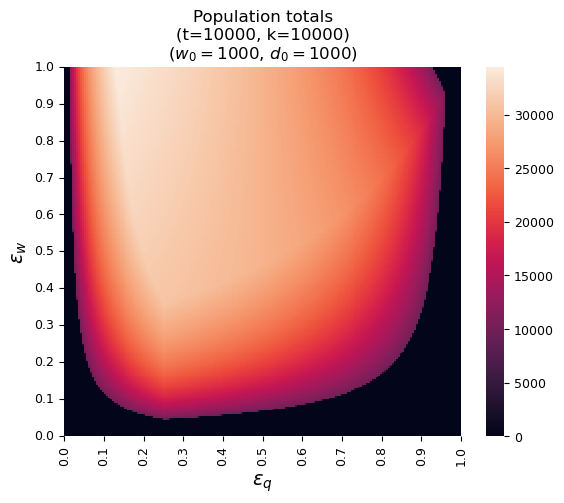

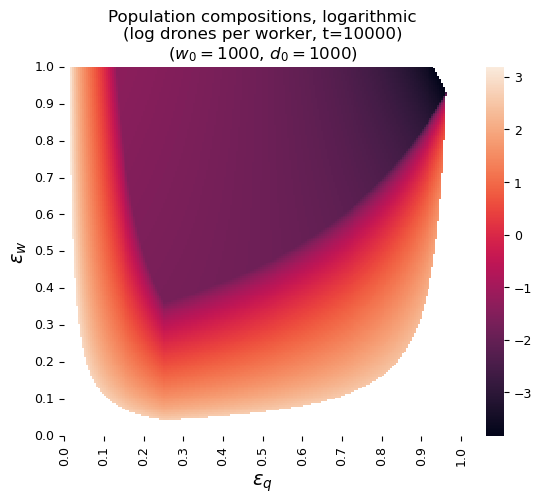

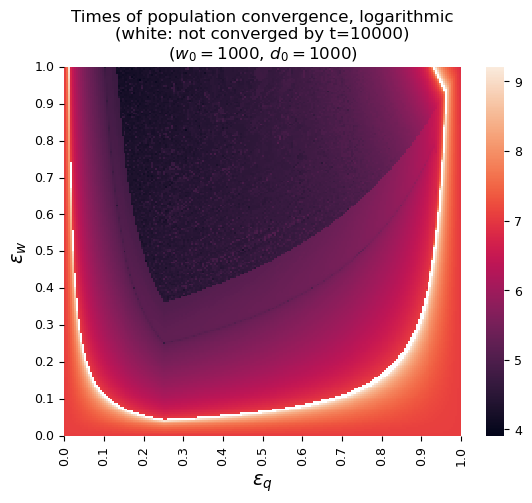

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[1205.10132732, 1921.06120728, 9244.79522484, ..., 1077.86195628,
          994.57636974,  940.34602392],
        [1205.10582422, 1913.56120787, 8872.28917292, ..., 1121.72156438,
         1031.67375586,  965.34602392],
        [1205.11033688, 1906.06122383, 8527.2831108 , ..., 1170.91214659,
         1060.35029929,  982.84602392],
        ...,
        [1176.51682667, 1179.02814437, 1181.53949906, ..., 1176.57177703,
         1176.56829006, 1174.06480677],
        [1176.52869206, 1176.53436094, 1179.04003908, ..., 1176.55615663,
         1176.55441836, 1176.55268102],
        [1176.54064315, 1176.54064315, 1176.54064315, ..., 1176.54064315,
         1176.54064315, 1176.54064315]]),
 array([[6.36484734e+03, 6.43333333e+01, 3.10000000e

In [15]:
##### defaults #####
config = {
    'tt': 10000,  # simulation timespan in units of 't'
    'k': 10000,  # carrying capacity, before exponential penalties kick in
    'w_0': 30.0,  # initial worker population
    'd_0': 5.0,  # initial drone population
    'l_w': 45.0,  # in units of 't', or time steps
    'l_d': 45.0,  # a 1/lifespan proportion will die in each time step, before penalties
    'e_w': 1.00,  # epsilon_w, proportion of energy donated by workers, 1.00 is optimal
    'e_q': 0.15,  # epsilon_q, proportion of energy donated by the queen, 0.15 is optimal
    'u_w': 3.0,  # cost for a worker to lay an egg
    'u_d': 0.5,  # cost for a drone to fertilize an egg (this kills the drone)
    'u_q': 1.5  # cost for the queen to lay an egg (economies of scale)
}

steps = 201

config['u_w'] = 6.0
config['u_d'] = 1.0
config['u_q'] = 3.0

simulate_heatmap(config, steps, show=True, title_note=f'($u_w={config["u_w"]}$, $u_d={config["u_d"]}$, $u_q={config["u_q"]}$)')

config['u_w'] = 1.5
config['u_d'] = 0.25
config['u_q'] = 0.75

simulate_heatmap(config, steps, show=True, title_note=f'($u_w={config["u_w"]}$, $u_d={config["u_d"]}$, $u_q={config["u_q"]}$)')

config['u_w'] = 3.0
config['u_d'] = 0.5
config['u_q'] = 1.5

config['l_w'] = 22.5
config['l_d'] = 22.5

simulate_heatmap(config, steps, show=True, title_note=f'($\\lambda_w={config["l_w"]}$, $\\lambda_d={config["l_d"]}$)')

config['l_w'] = 90
config['l_d'] = 90

simulate_heatmap(config, steps, show=True, title_note=f'($\\lambda_w={config["l_w"]}$, $\\lambda_d={config["l_d"]}$)')

config['l_w'] = 45
config['l_d'] = 45

config['w_0'] = 1
config['d_0'] = 1

simulate_heatmap(config, steps, show=True, title_note=f'($w_0={config["w_0"]}$, $d_0={config["d_0"]}$)')

config['w_0'] = 1000
config['d_0'] = 1000

simulate_heatmap(config, steps, show=True, title_note=f'($w_0={config["w_0"]}$, $d_0={config["d_0"]}$)')